# Pipeline Testing Notebook for Cropland Mapping

This notebook tests the functionality of the cropland mapping training and inference pipeline. We use sample data (exported from `export_pipeline`) and the modules we've defined to verify that all components work together correctly. 


1. **Test Training Pipeline** (`scripts/train.py`)
  - Testing model creation with proper architecture
  - Testing backbone freezing functionality
  - Running a small training loop

2. **Test Inference Pipeline** (`scripts/inference.py`)
  - Loading pre-trained model
  - Running inference on sample chips
  - Testing prediction writing to local and GCS storage

3. **Visualize Inference Results**
  - Display some chips from numpy.

## Sample Data
We use a small subset of real data to test the pipeline:

**Training Data** (`sample_data/train/`)
 - Contains a single TFRecord file with 512x512 patches
 - Each patch has 6 input bands (NDVI, NBR2, NDMI, grass, woody, ground)
 - Includes binary cropland labels

**Evaluation Data** (`sample_data/eval/`)
 - Similar structure to training data
 - Used for validation during training tests

**Inference Data** (`sample_data/inference/`)
 - Sample inference chips
 - Contains only input bands (no labels)
 - Used to test prediction pipeline

**NOTE**: If you were to run this yourself, you would have to change both config files in `config/`. You'll have to define your own google cloud bucket, as well as machine-specific parameters including memory size and GPU access. This currenly runs on my laptop. 


In [1]:
import sys
sys.path.append('../')

import tensorflow as tf
from pathlib import Path
import yaml
import glob

from src.config import TrainingConfig, InferenceConfig
from src.data_loading import get_training_dataset, get_eval_dataset
from src.model_utils import dice_coef, dice_loss

# 1. Test Training Pipeline

In [2]:
# Test model creation and training functions
from scripts.train import create_model, setup_gpu_memory, freeze_backbone
from src.config import TrainingConfig
from src.data_loading import get_training_dataset, get_eval_dataset, get_regional_dataset
from src.model_utils import dice_coef, dice_loss
from scripts.inference import write_predictions
from keras_unet_collection.losses import focal_tversky


In [3]:

def test_training():
    """Test the complete training pipeline using a small sample of data.
    
    This function tests:
    1. Configuration loading from YAML
    2. GPU memory setup
    3. Data loading with TFRecords
    4. Model creation with correct architecture
    5. Model compilation with custom loss/metrics
    6. Training for a few epochs
    
    The function uses reduced batch sizes and steps for memory efficiency
    during testing.
    
    Returns:
        tuple: (model, history)
            - model: Trained Keras model
            - history: Training history object
    
    Requires:
        - Valid train_config.yaml
        - Sample TFRecord files in sample_data/train and sample_data/eval
    """
    
    # Initialize configuration
    train_config = TrainingConfig('configs/train_config.yaml')

    # Get sample training data
    paths = train_config.get_paths()
    train_pattern = f"{paths['data_folder']}{paths['train_base']}*.tfrecord.gz"
    eval_pattern = f"{paths['data_folder']}{paths['eval_base']}*.tfrecord.gz"
    
    training = get_training_dataset(
        pattern=train_pattern,
        features_dict=train_config.get_features_dict(),
        features=train_config.input_bands,
        batch_size=1, # Just for testing purposes. would be train_config.batch_size typically
        compressed=train_config.is_compressed
    )

    evaluation = get_eval_dataset(
        pattern=eval_pattern,
        features_dict=train_config.get_features_dict(),
        features=train_config.input_bands,
        compressed=train_config.is_compressed
    )
    
    # Create model using our function
    print('Creating new model')
    model = create_model(len(train_config.input_bands))
    
    # Apply freezing strategy
    freeze_backbone(model, train_config.backbone_freeze)
    print("Model prepared successfully")
    
    # Rest of training setup from train.py
    optimizer = tf.keras.optimizers.Adamax(
        learning_rate=train_config.learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
    )
    
    loss_fn = focal_tversky if train_config.loss_function == "focal_tversky" else dice_loss
    
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            tf.keras.metrics.MeanIoU(num_classes=2),
            dice_coef,
            'accuracy'
        ],
        run_eagerly=True
    )
    
    # Train for just 2 epochs
    history = model.fit(
        x=training,
        epochs=2,
        steps_per_epoch=2,
        validation_data=evaluation,
        validation_steps=2
    )
    
    return model, history

In [4]:
test_training()

Reading 1 compressed files
Reading 1 compressed files
Creating new model


Model prepared successfully
Epoch 1/2
2/2 [==============================] - 5s 3s/step - loss: 0.8898 - mean_io_u: 0.4612 - dice_coef: 0.1432 - accuracy: 0.5872 - val_loss: 0.9244 - val_mean_io_u: 0.4726 - val_dice_coef: 0.0994 - val_accuracy: 0.0588
Epoch 2/2
2/2 [==============================] - 5s 3s/step - loss: 0.8734 - mean_io_u: 0.4612 - dice_coef: 0.1641 - accuracy: 0.6250 - val_loss: 0.9244 - val_mean_io_u: 0.4726 - val_dice_coef: 0.0995 - val_accuracy: 0.0585


(<keras.src.engine.functional.Functional at 0x303551a30>,
 <keras.src.callbacks.History at 0x303587bb0>)

# 2. Test Inference Pipeline

In [68]:
infer_config = InferenceConfig('configs/inference_config.yaml')
infer_config.is_compressed

True

In [66]:
def test_inference():
    """Test the complete inference pipeline using a pre-trained model. Uses configs/inference_config.yaml. 
    
    This function tests:
    1. Loading a trained model with custom metrics
    2. Loading and processing inference data
    3. Making predictions on new data
    4. Storing predictions as a numpy array and writing to GCS (optional)
    
    The function processes sample inference chips and tests both local
    and cloud storage writing capabilities.
    
    Returns:
        numpy.ndarray: Model predictions on the test data
        
    Requires:
        - Valid inference_config.yaml
        - Pre-trained model at specified path
        - Sample TFRecord files in sample_data/inference
        - [Optional] GCS credentials for cloud storage testing

    """

    # Initialize configuration
    infer_config = InferenceConfig('configs/inference_config.yaml')
    
    # Load existing model with custom metrics
    model = tf.keras.models.load_model(
        infer_config.get_paths()['existing_model'],
        custom_objects={
            'dice_coef': dice_coef,
            'dice_loss': dice_loss,
            'focal_tversky': focal_tversky
        },
        compile=False
    )
    print("Model loaded successfully")
    
    # Get sample inference data
    test_files = glob.glob(f"{infer_config.get_paths()['input_folder']}/*.tfrecord.gz")
    print(f"Found {len(test_files)} files to process")
    
    # Create dataset
    dataset = get_regional_dataset(
        image_list=test_files,
        features_dict=infer_config.get_features_dict(),
        features=infer_config.input_bands,
        compressed=infer_config.is_compressed
    )
    
    # Run predictions
    print("Running predictions...")
    predictions = model.predict(dataset, verbose=1)
    print(f"Predictions shape: {predictions.shape}")
    
    output_path = "test_predictions.tfrecord"
    
    # OPTIONAL: GCS write (if configured)
    # gcloud_output = infer_config.get_paths()['gcloud_output']
    # if gcloud_output.startswith('gs://'):
    #     gcs_output = f"{gcloud_output}test_predictions.tfrecord"
    #     write_predictions(predictions, gcs_output)
    #     print(f"Predictions saved to GCS: {gcs_output}")
    
    return predictions


# Test inference
predictions = test_inference()


Model loaded successfully
Found 1 files to process
Running predictions...
161/161 [==============================] - 51s 318ms/step
Predictions shape: (161, 512, 512, 1)


# 3. Visualize results from trained model inference

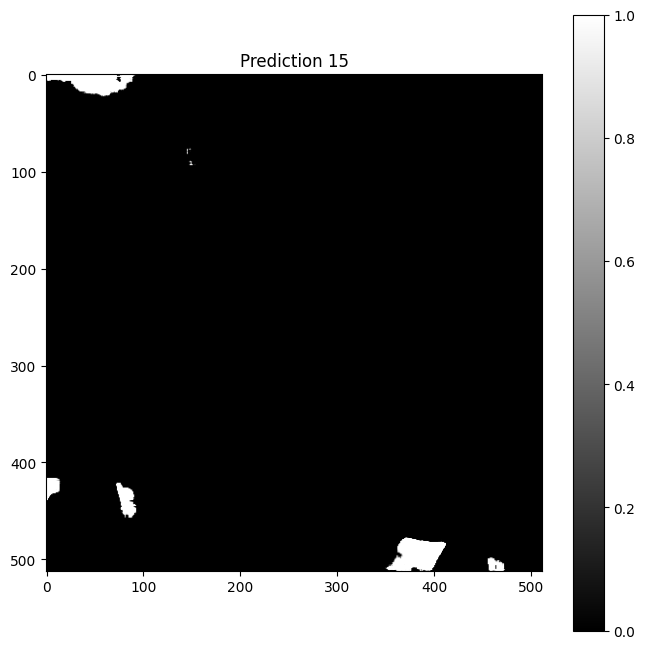

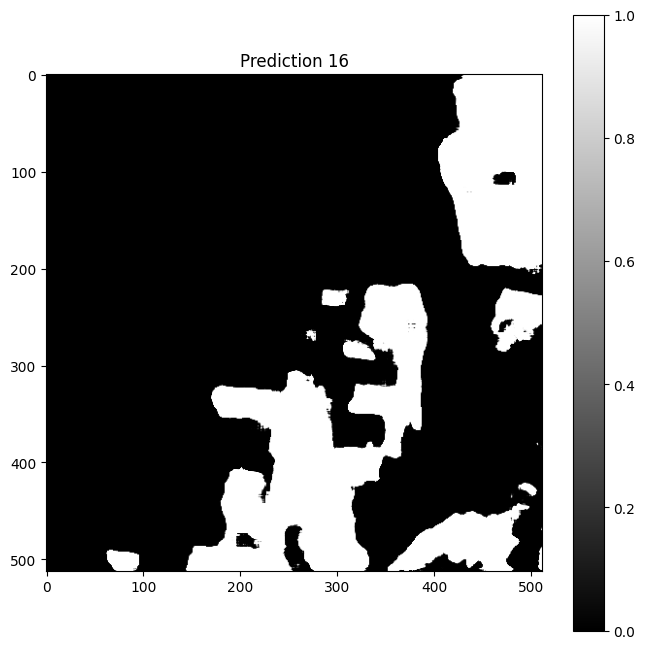

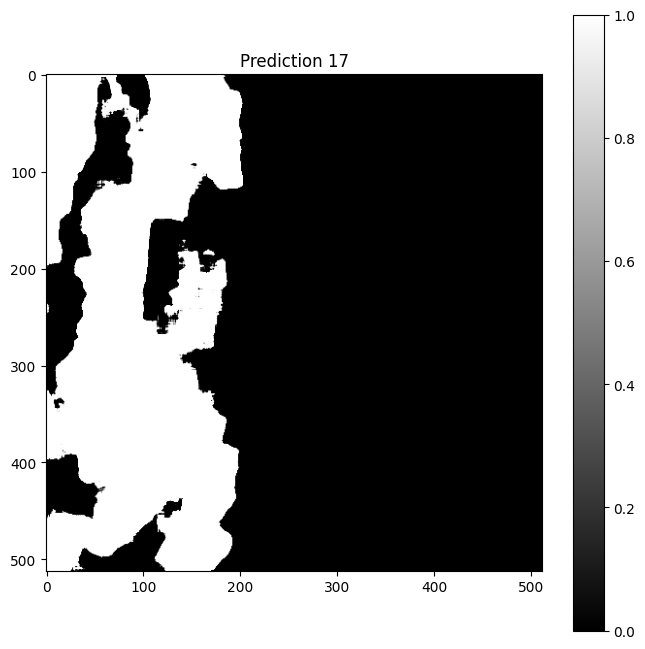

In [67]:
# Visualize predictions
import matplotlib.pyplot as plt

for i in [14,15,16]:  # Show some random predictions
    plt.figure(figsize=(8, 8))
    plt.imshow(predictions[i, :, :, 0], cmap='gray')  # Use first channel
    plt.colorbar()
    plt.title(f'Prediction {i+1}')
    plt.show()